In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [2]:
# load data
### load train and test set

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# outlier detection

def detect_outlier(df, n, features):
    '''
    takes a dataframe df of features and returns a list of the indices corresponding to the 
    observations containing more than n outliers according to the tukey method.
    '''
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5*IQR
        
        # determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
    
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

# detect outliers from Age, Sibsp, Parch and Fare
outliers_to_drop = detect_outlier(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])


- outlier의 경우 prediction에 영향을 크게 미칠 수 있기 때문에(특히 회귀의 경우 더욱) 삭제함
- Tukey method를 사용하여 outlier를 찾고 비교함 (IQR)

In [4]:
train.loc[outliers_to_drop] # show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
# drop outliers
train = train.drop(outliers_to_drop, axis=0).reset_index(drop=True)

In [6]:
# join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [7]:
# fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [8]:
# infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
### summarize data
# summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


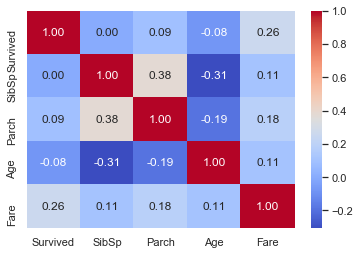

In [11]:
# correlation matrix between numerical values (SibSp, Parch, Age and Fare values) and Survived
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt = '.2f',
               cmap = 'coolwarm')

- Fare가 survived에 가장 큰 영향을 미치는 것으로 보이나, 다른것들의 의미가 없는게 아님
- 소집단도 생존에 영향을 미칠 수 있으므로 자세히 살펴봐야 함

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


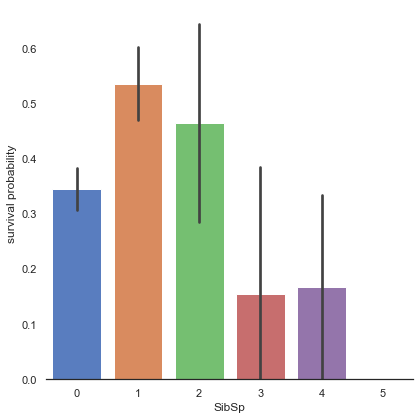

In [12]:
# Explore SibSp feature vs Survived
g = sns.factorplot('SibSp', 'Survived', data = train, kind='bar', size = 6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 가족 규모가 클수록 생존확률이 적었고, 혼자거나 2명 이내의 소규모일 경우의 생존확률이 높았음
- 이를 고려하여 새롭게 범주형 변수를 구성할 예정

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


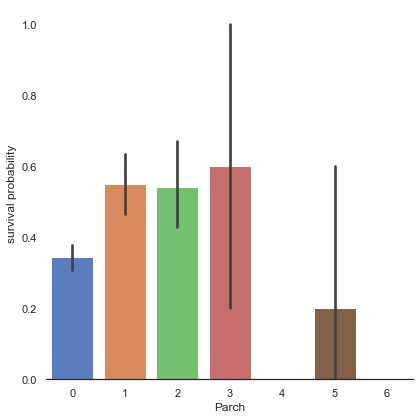

In [13]:
# Explore Parch feature vs Survived
g = sns.factorplot('Parch', 'Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 소가족의 경우가 나머지 부분들에 비해서 생존확률이 높았다(부모/자식 수가 3명의 경우 편차가 크다)

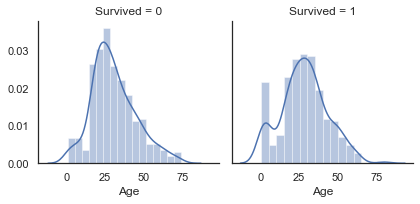

In [14]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

- 나이의 분포는 꼬리분포, 아마 정규분포의 형태인듯
- 또한 나이가 생존과 상관되지 않더라도 생존할 확률에 관한 나이 범주가 있음을 알 수 있음

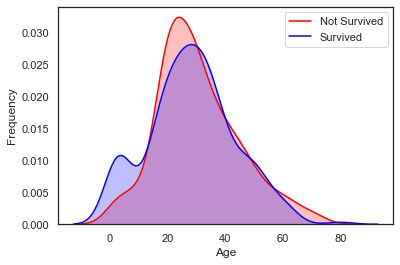

In [15]:
# expldoe age distribution
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], color='Blue',shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

- 0~5 세 사이에서의 차이를 뚜렷이 볼 수 있음

In [16]:
dataset['Fare'].isnull().sum()

1

In [17]:
# Fill Fare missing values with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

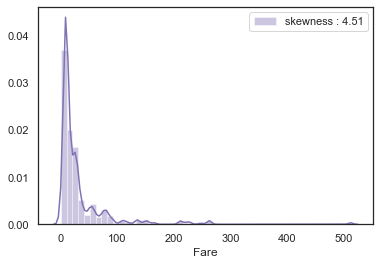

In [18]:
# explode fare distribution
g = sns.distplot(dataset['Fare'], color='m', label='skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc = 'best')

- 왜도가 4.51로 매우 높다 -> log 스케일링을 해본다


- Skewed 데이터를 변환하는 이유는 꼬리에 있는 값을 모델에 제대로 학습시키기 위함이다. Skewed 되어있는 값을 그대로 학습시키면 꼬리 부분이 상대적으로 적고 멀어서 모델에 영향이 거의 없이 학습된다. 만약 꼬리 부분도 노이즈가 아닌 정말 유의미한 데이터이면 꼬리 부분에 해당하는 test 데이터는 예측력이 낮아진다.
- 변환을 해서 들어가게 되면 그만큼 데이터의 중간값(or 평균값)가 tail 하고 가까워져서 모델에 보다 크게 들어간다. 그렇게 되면 꼬리 쪽에 해당하는 test 데이터가 들어와도 예측력이 높아진다.

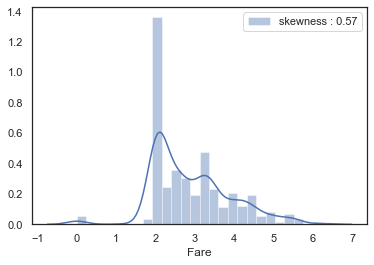

In [19]:
# Apply log to Fare reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

g = sns.distplot(dataset['Fare'], color='b', label='skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc = 'best')

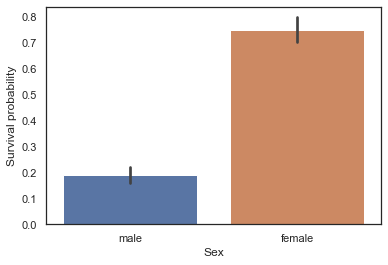

In [20]:
g = sns.barplot('Sex', 'Survived', data=train)
g = g.set_ylabel('Survival probability')

In [21]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 육안으로도 데이터로도 차이가 옴총  : 생존에 중요한 요소로 작용

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


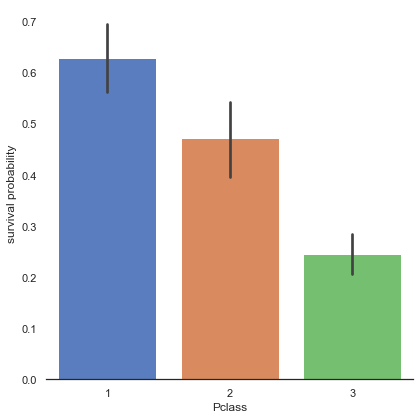

In [22]:
# explode Pclass vs Survived
g = sns.factorplot('Pclass', 'Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


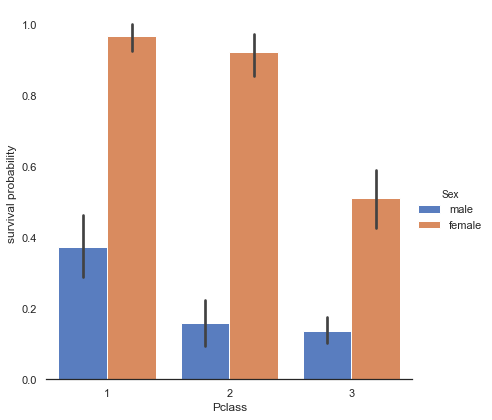

In [23]:
# explode Pclass vs Survived by Sex
g = sns.factorplot('Pclass', 'Survived', hue='Sex', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g.set_ylabels('survival probability')

- 클래스가 낮을수록 생존확률이 높다

In [24]:
dataset['Embarked'].isnull().sum()

2

In [25]:
# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset['Embarked'] = dataset['Embarked'].fillna('S')

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


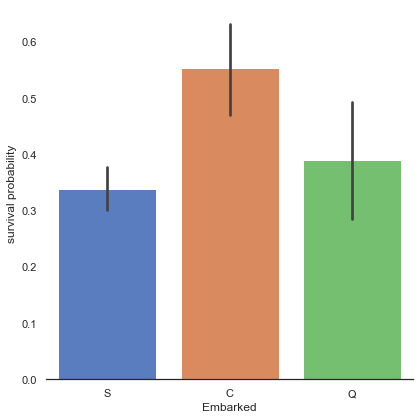

In [26]:
# explode Embarked vs Survived

g = sns.factorplot('Embarked', 'Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g.set_ylabels('survival probability')

- C 항구에서 온 사람들이 1등석 비율이 높을 수 있다는 가설

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


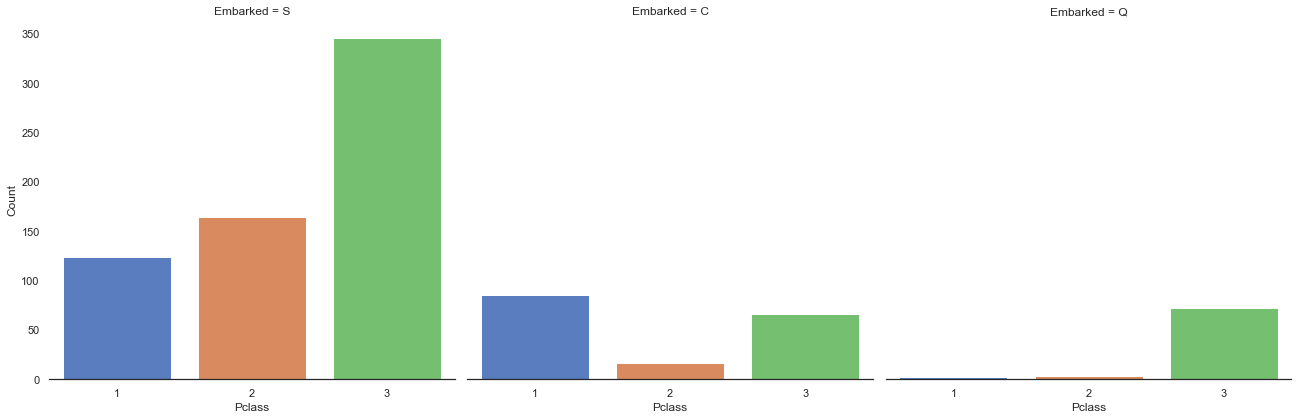

In [27]:
# explode Pclass vs Embarked
g = sns.factorplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g.despine(left=True)
g.set_ylabels('Count')

- C항구의 대부분은 1등석, 나머지랑 비교됨

- Age 는 256개의 결측치가 있음. 연령특성을 유지하면서 결측값을 돌리게끔 유도함
- 이를 위해 Age와 관련이 있는 특징을 살펴봄

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(

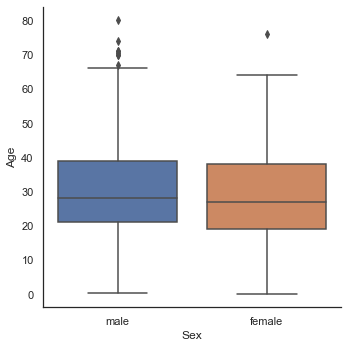

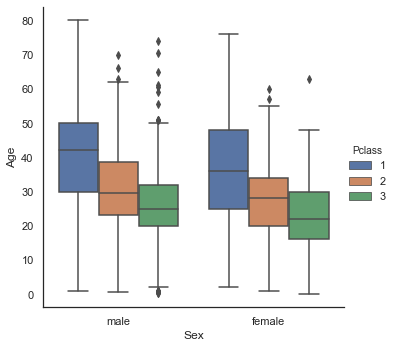

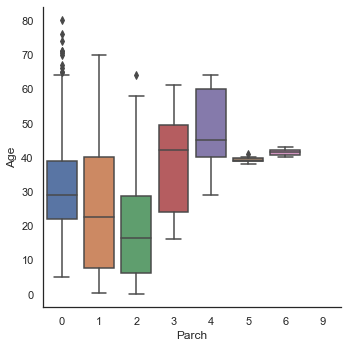

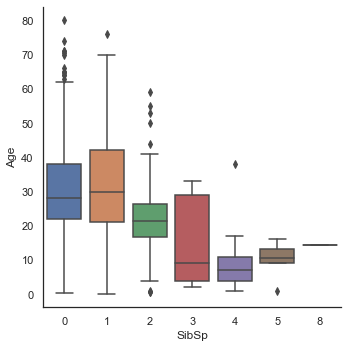

In [28]:
g = sns.factorplot('Sex', 'Age', data=dataset, kind='box')
g = sns.factorplot('Sex', 'Age', hue='Pclass', data=dataset, kind='box')
g = sns.factorplot('Parch', 'Age', data=dataset, kind='box')
g = sns.factorplot('SibSp', 'Age', data=dataset, kind='box')

- pclass 등급별로 age 연령의 차이가 보임,
- 나이가 많을수록 parch값이 높아지고 어릴수록 sibsp값이 높아짐

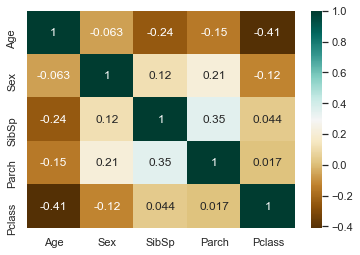

In [29]:
# convert Sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

- The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp

In [30]:
# Filling missing value of Age
## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & 
                               (dataset['Parch'] == dataset.iloc[i]['Parch']) &
                              (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    
    else:
        dataset['Age'].iloc[i] = age_med

C:\Users\USER\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


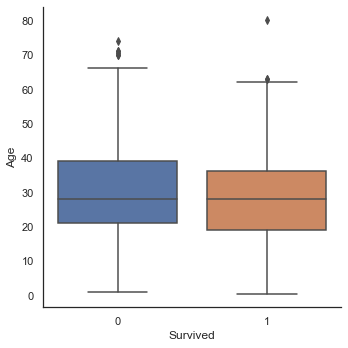

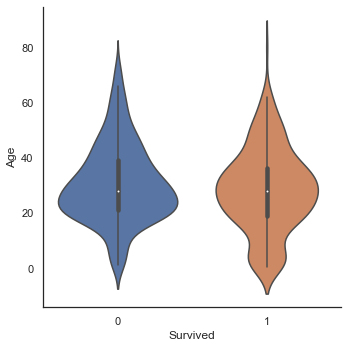

In [40]:
g = sns.factorplot(x='Survived', y='Age', data=train, kind='box')
g = sns.factorplot(x='Survived', y='Age', data=train, kind='violin')

In [41]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [43]:
# get title from name
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset["Title"] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

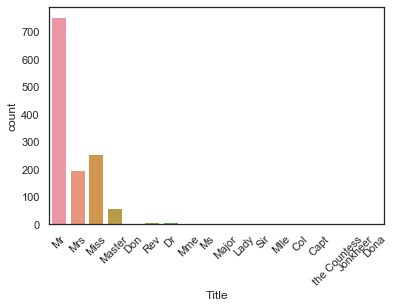

In [44]:
g = sns.countplot('Title', data=dataset)
plt.setp(g.get_xticklabels(), rotation=45)

In [45]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 
                                             'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, 
                                         "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

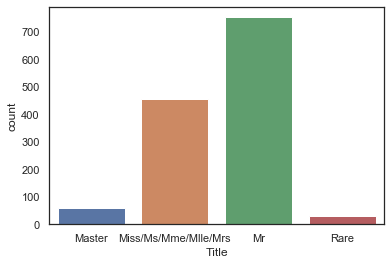

In [46]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


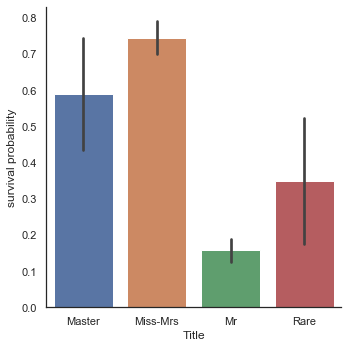

In [47]:
g = sns.factorplot('Title', 'Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

In [48]:
dataset.drop(['Name'], axis=1, inplace=True)

In [49]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


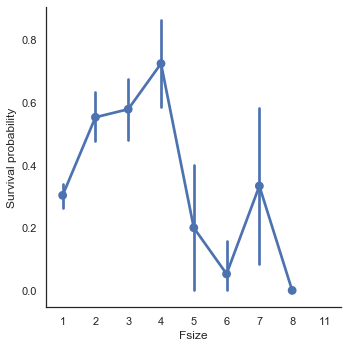

In [50]:
g = sns.factorplot('Fsize', 'Survived', data=dataset)
g = g.set_ylabels('Survival probability')

- 가족 규모는 생존에 중요한 영향을 미칠 수 있음을 확인

In [51]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda x: 1 if x == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda x: 1 if 2<= x <= 3 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda x: 1 if x == 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda x: 1 if x >= 5 else 0)

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(

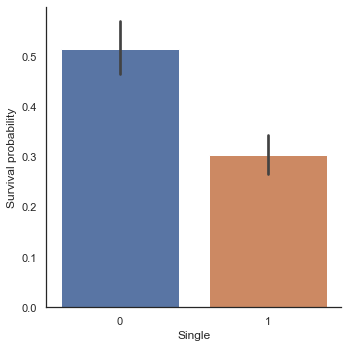

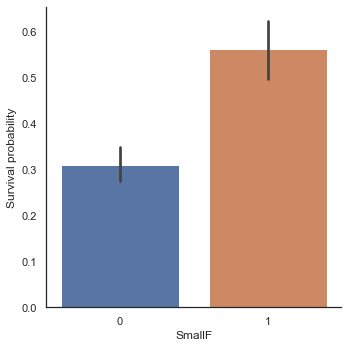

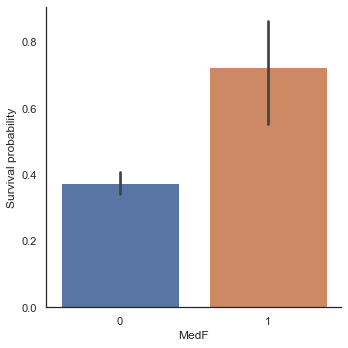

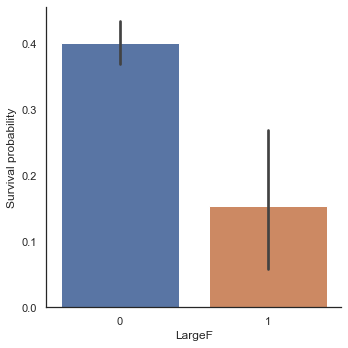

In [54]:
g = sns.factorplot('Single', 'Survived', data=dataset, kind='bar')
g.set_ylabels('Survival probability')

g = sns.factorplot('SmallF', 'Survived', data=dataset, kind='bar')
g.set_ylabels('Survival probability')

g = sns.factorplot('MedF', 'Survived', data=dataset, kind='bar')
g.set_ylabels('Survival probability')

g = sns.factorplot('LargeF', 'Survived', data=dataset, kind='bar')
g.set_ylabels('Survival probability')

In [55]:
# convert to indicator values title and embarked
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix = 'Em')
dataset

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1305,NaN,3,0,25.0,0,0,A.5. 3236,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1
1295,1306,NaN,1,1,39.0,0,0,PC 17758,4.690430,C105,...,0,0,0,0,0,0,1,1,0,0
1296,1307,NaN,3,0,38.5,0,0,SOTON/O.Q. 3101262,1.981001,NaN,...,0,0,0,0,0,1,0,0,0,1
1297,1308,NaN,3,0,25.0,0,0,359309,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


In [57]:
dataset['Cabin'].isnull().sum()

1007

In [58]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

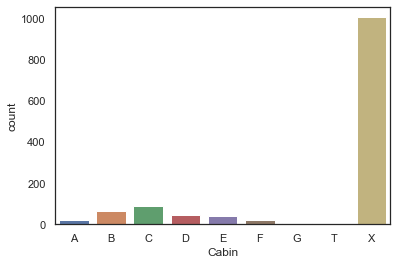

In [59]:
g = sns.countplot(dataset['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


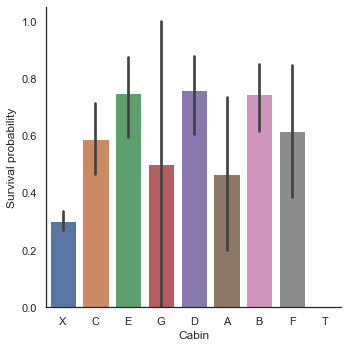

In [60]:
g = sns.factorplot('Cabin', 'Survived', data=dataset, kind='bar')
g.set_ylabels('Survival probability')

In [62]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

In [63]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [64]:
## Treat Ticket by extracting the ticket prefix. when there is no prefix it returns X

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace('/',"").strip().split(' ')[0]) # take prefix
    else:
        Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [65]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [66]:
# create categorical values for pclass

dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns= ['Pclass'], prefix='Pc')

In [67]:
# drop unless variables
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [70]:
## separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ['Survived'], axis = 1, inplace=True)

C:\Users\USER\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [71]:
## seperate train features and label
train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
# CV model with Kfold stratified cross val

kfold = StratifiedKFold(n_splits=10)

Text(0.5, 1.0, 'CV scores')

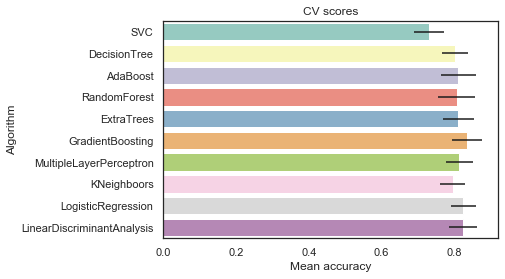

In [78]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                     random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring='accuracy', cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'CrossValMeans':cv_means, 'CrossValerros':cv_std, 
                       'Algorithm':["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTrees",
                                    "GradientBoosting","MultipleLayerPerceptron","KNeighboors",
                                    "LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean accuracy')
g.set_title('CV scores')

In [80]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {'base_estimator__criterion':['gini', 'entropy'],
                 'base_estimator__splitter':['bset','random'],
                 'algorithm':['SAMME', 'SAMME.R'],
                 'n_estimators':[1,2],
                 'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4,
                        verbose=True)

ada_best = gsadaDTC.fit(X_train, Y_train)

print(ada_best)
print(gsadaDTC.best_score_)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                           

[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    3.7s finished


In [81]:
# extratrees
ExtC = ExtraTreesClassifier()

## search grid for optimal parameters
ex_param_grid = {'max_depth':[None],
                'max_features':[1, 3, 10],
                'min_samples_split':[2,3,10],
                'min_samples_leaf':[1,3,10],
                'bootstrap':[False],
                'n_estimators':[100,300],
                'criterion':['gini']}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=True)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_
print(ExtC_best)
print(gsExtC.best_score_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 533 out of 540 | elapsed:   38.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   38.8s finished


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features=3,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=3, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=300,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
0.8331460674157303


In [83]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()

gb_param_grid = {'loss':['deviance'],
                'n_estimators':[100,200,300],
                'learning_rate':[0.1,0.05,0.01],
                'max_depth':[4, 8],
                'min_samples_leaf':[100,150],
                'max_features':[0.3,0.1]}

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=True)

gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_

print(GBC_best, gsGBC.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   12.5s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=0.3, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=150, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) 0.8297242083758937


[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   24.1s finished


In [84]:
# SVC classifier
SVMC = SVC(probability=True)

svc_param_grid = {'kernel':['rbf'],
                 'gamma':[0.001, 0.01,0.05,0.1,0.2,0.5,1],
                 'C':[0.1,0.5,1,2,5,10,50,100,200,500,1000]}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, 
                      verbose=True)
gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

print(SVMC_best, gsSVMC.best_score_)

Fitting 10 folds for each of 77 candidates, totalling 770 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 770 out of 770 | elapsed:   55.8s finished


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False) 0.8331332992849847


In [92]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   38.6s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   47.6s finished


0.8342951991828398

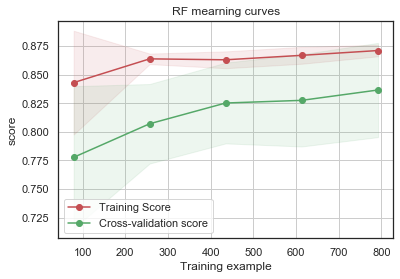

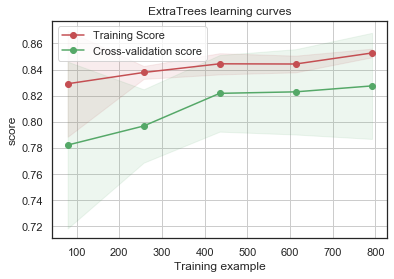

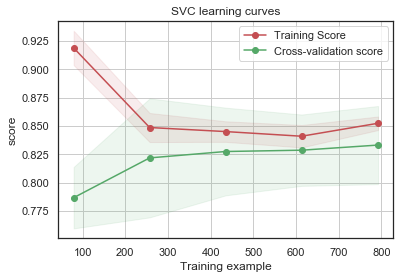

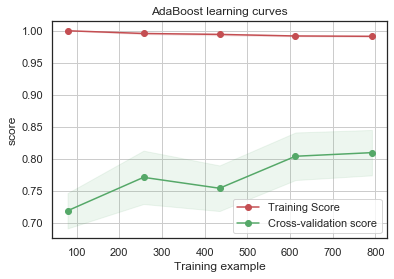

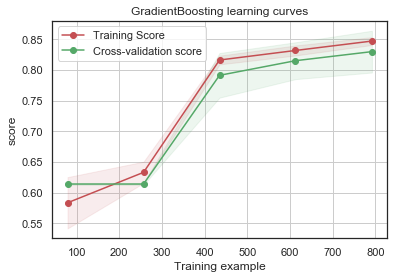

In [93]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1,
                       train_sizes=np.linspace(.1, 1.0, 5)):
    '''Generate a simple plot of the test and training learning curve'''
    
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel('Training example')
    plt.ylabel('score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                                                           train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

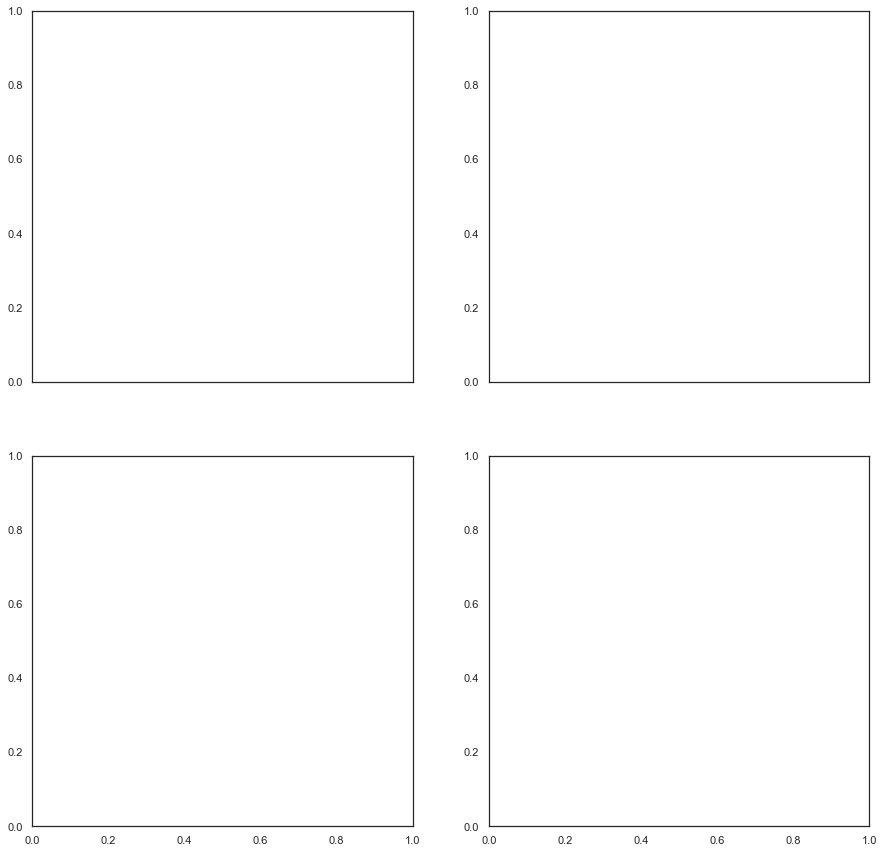

In [94]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),
                     ("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40], 
                        orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

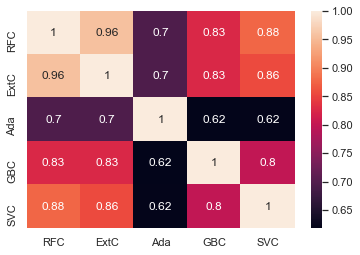

In [99]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, 
                              test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [100]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best),
                                      ('adac', ada_best), ('gbc', GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [104]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")